In [30]:
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

In [28]:
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

In [29]:
def data2query(
                row,
                col_names = [
                            'Operating System', 'Application Server', 'Front End', 'Back End',
                            'Database', 'Processor', 'Speed', 'RAM', 'SSD', 'Hard Disk', 'Device',
                            'Framework', 'Source control tools', 'IDE'
                ]):
    query = {}
    for col in col_names:
        query[col] = row[col]
    row["query"] = f"""{query}"""
    return row

def load_data(
                class_dict = {
                            "L1" : 0,
                            "L2" : 1,
                            "L3" : 2,
                            }
                ):
    data = pd.read_excel('data/Technical_Data.xlsx')
    data.columns = [col.strip() for col in data.columns]
    del data['Project ID']

    Y = data['Feasibility Level']
    X = data.drop('Feasibility Level', axis=1)
    X = X.apply(data2query, axis=1)
    Y = Y.map(class_dict)
    X = X['query'].values
    Xemb = embed_model.get_text_embedding_batch(X)
    Xemb = np.array(Xemb)
    
    return Xemb, Y
    

In [31]:
Xemb, Y = load_data()
X_train, X_test, Y_train, Y_test = train_test_split(
                                                    Xemb, Y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (224, 384)
X_test shape: (56, 384)
Y_train shape: (224,)
Y_test shape: (56,)


In [34]:
cb = CatBoostClassifier(
                        iterations=1000,
                        learning_rate=0.1, depth=5,
                        loss_function='MultiClass',
                        verbose=100
                        )

cb.fit(Xemb, Y)

0:	learn: 1.0901682	total: 34.9ms	remaining: 34.9s
100:	learn: 0.4048478	total: 2.67s	remaining: 23.8s
200:	learn: 0.1857357	total: 5.44s	remaining: 21.6s
300:	learn: 0.1057754	total: 8.09s	remaining: 18.8s
400:	learn: 0.0687250	total: 10.8s	remaining: 16.2s
500:	learn: 0.0492900	total: 13.7s	remaining: 13.6s
600:	learn: 0.0378852	total: 16.4s	remaining: 10.9s
700:	learn: 0.0302803	total: 19.2s	remaining: 8.18s
800:	learn: 0.0245385	total: 21.9s	remaining: 5.45s
900:	learn: 0.0207242	total: 24.7s	remaining: 2.72s
999:	learn: 0.0179409	total: 27.5s	remaining: 0us


In [35]:
P_train = cb.predict(X_train)
P_test = cb.predict(X_test)

cls_report_train = classification_report(Y_train, P_train)
cls_report_test = classification_report(Y_test, P_test)

print(f"Train Classification Report:\n{cls_report_train}")
print(f"Test Classification Report:\n{cls_report_test}")

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      1.00        78
           2       1.00      1.00      1.00        78

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        14

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



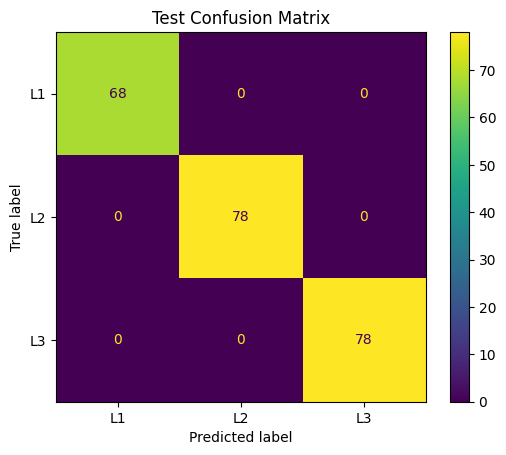

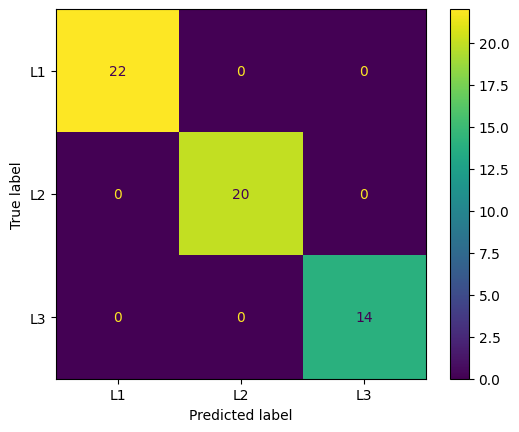

In [37]:
cm_train = confusion_matrix(Y_train, P_train)
cm_test = confusion_matrix(Y_test, P_test)

disp = ConfusionMatrixDisplay(
                            confusion_matrix = cm_train,
                            display_labels = ['L1', 'L2', 'L3']
                            )               
disp.plot()

disp = ConfusionMatrixDisplay(
                            confusion_matrix = cm_test,
                            display_labels = ['L1', 'L2', 'L3']
                            )                  
plt.title('Test Confusion Matrix') 
disp.plot()

In [38]:
with open('artifacts/technical_cls.pkl', 'wb') as f:
    pickle.dump(cb, f)

### Inference

In [43]:
with open('artifacts/technical_cls.pkl', 'rb') as f:
    cls = pickle.load(f)

In [48]:
def data2query(
                row,
                col_names = [
                            'Operating System', 'Application Server', 'Front End', 'Back End',
                            'Database', 'Processor', 'Speed', 'RAM', 'SSD', 'Hard Disk', 'Device',
                            'Framework', 'Source control tools', 'IDE'
                ]):
    query = {}
    for col in col_names:
        query[col] = row[col]
    row["query"] = f"""{query}"""
    return row

def inference_technical(
                        sample_data,
                        class_dict = {
                                    0 : "L1",
                                    1 : "L2",
                                    2 : "L3"
                                    }
                        ):
    sample_data = pd.DataFrame(sample_data, index=[0])
    sample_data = sample_data.apply(data2query, axis=1)
    X = sample_data['query'].values
    Xemb = embed_model.get_text_embedding_batch(X)
    Xemb = np.array(Xemb)
    pred = cls.predict(Xemb)
    return class_dict[int(pred[0])]

In [ ]:
sample_data = {
            "Operating System":"Android 10",
            "Application Server":10,
            "Front End":"React Native",
            "Back End":"Node.js",
            "Database":"Oracle Database",
            "Processor":"AMD Ryzen 5",
            "Speed":"2GHz",
            "RAM":"64GB RAM",
            "SSD":"1TB SSD",
            "Hard Disk":"500GB",
            "Device":"Smartphone",
            "Framework":"Langchain",
            "Source control tools":"GitHub",
            "IDE":"Visual Studio Code"
            }

In [49]:
inference_technical(sample_data)

'L2'